### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.
* This homework uses Pytorch v1.x: this is [how you install it](https://pytorch.org/get-started/locally/); and that's [how you use it](https://github.com/yandexdataschool/Practical_RL/tree/9f89e98d7df7ad47f5d6c85a70a38283e06be16a/week04_%5Brecap%5D_deep_learning).

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [83]:
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

--2020-12-04 15:47:38--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2020-12-04 15:47:38--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca632855c6e116d885833b814f8.dl.dropboxusercontent.com/cd/0/get/BEfTt8_gD3IuNm9LlE6akK2KLaJbj2o0SM2daOpE0IV5gGdHSwuv_xg-2OS298D-7G-H4oepO7hVofMawNdefuI8q_2EYN-Al0zo3icA_86nEw/file?dl=1# [following]
--2020-12-04 15:47:38--  https://uca632855c6e116d885833b814f8.dl.dropboxusercontent.com/cd/0/get/BEfTt8_gD3IuNm9LlE6akK2KLaJbj2o0SM2daOpE0IV5gGdHSwuv_xg-2OS298D-7G-H4oepO7hVofMawNdefuI8q_2EYN-Al0zo3icA_8

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [84]:
# get all unique characters from lines (including capital letters and symbols)
tokens = set(''.join(line for line in lines))

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [85]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [86]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [87]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [88]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))

[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (2 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [91]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, device, n_tokens=n_tokens, emb_size=16, hid_size=64, kernel_size=5):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        
        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        self.device = device
        self.kernel_size = kernel_size
        
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.conv = nn.Conv1d(in_channels=emb_size,
                              out_channels=hid_size,
                              kernel_size=kernel_size)
        # self.batch_norm = nn.BatchNorm1d(num_features=hid_size)
        self.fc1 = nn.Linear(in_features=hid_size, out_features=2 * hid_size)
        self.fc2 = nn.Linear(in_features=2 * hid_size, out_features=n_tokens)
        self.relu = nn.ReLU()
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
            
        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        out = self.emb(input_ix) # (batch_size, sequence_length, emb_dim)
        out = out.permute((0, 2, 1)) # (batch_size, emb_dim, sequence_length)

        # adding padding on the left side
        out = F.pad(out, pad=(self.kernel_size - 1, 0))

        out = self.conv(out) # (batch_size, hid_dim, sequence_length)
        # out = self.batch_norm(out)
        out = self.relu(out)
        out = out.permute((0, 2, 1)) # (batch_size, sequence_length, hid_dim)
        out = self.fc1(out) # (batch_size, sequence_length, n_tokens)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(self.device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [92]:
dummy_model = FixedWindowLanguageModel(device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv.weight', 'conv.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias')


In [93]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [94]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [95]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [96]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)
    
    logits = model(input_ix[:, :-1]) # (batch_size, sequence_length - 1, n_tokens)
    target = input_ix[:, 1:]
    
    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))

    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = F.log_softmax(logits_flat, dim=1)

    # target_flat: (batch * max_len, 1)
    target_flat = target.reshape(-1, 1)

    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)

    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())

    # mask: (batch, max_len)
    mask = compute_mask(input_ix[:, 1:]).to(torch.int32)
    
    losses = losses * mask
    loss = losses.sum() / sum(mask.sum(-1))
    return loss

In [97]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [98]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = torch.as_tensor(to_matrix(dev_lines[i: i + batch_size])).to(device)
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [99]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
cnn_model = FixedWindowLanguageModel(device)
opt = torch.optim.Adam(cnn_model.parameters())
cnn_model.to(device)

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained cnn_model
dev_history.append((0, score_lines(cnn_model, dev_lines, batch_size)))
print("Sample before training:", generate(cnn_model, 'Bridging'))

Sample before training: BridgingΠwaôyTλïÉc=°γσ4g%=°ö5pTsX-X)βRmIN^Ü/'[VW2õíHIσ'ãρbO \fziqερ(câLöl hÉ`H^(gγΩT1bãn$iAæx9ÜwèZ°W)


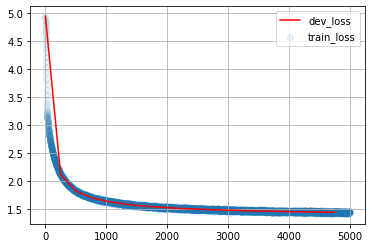

Generated examples (tau=0.5):
 Propose the statistical and a communication image discribe the well exploy decoding problems are sin
 Matchmetric models to the most explayer of the for accers the can between to a set of semation of th
 Gaussion a learning a single computation where language to the orthod solvergence to address the of 
Scoring dev...


100%|██████████| 5000/5000 [04:03<00:00, 20.55it/s]

#4999 Dev loss: 1.436


In [100]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = torch.as_tensor(to_matrix(sample(train_lines, batch_size))).to(device)
    
    loss_i = compute_loss(cnn_model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(cnn_model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(cnn_model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [105]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(cnn_model, temperature=0.5))

Final dev loss: 1.4361611883116931
 Programeters are and Space and and in the matrix in the detecting the traction of a lates to be expl
 Regular for Search in a set of the specification is a step learning and recognitional and show that 
 Areation for the control neural networks (MT) are of the to a computer the models are aboos for usin
 Bayesian and problem of a supervised and to images the semantics (APP) are deep learning Are of the 
 Model for the real-data for Compute the represent approach to a size selection ; The not task are or
 Models are to the computer variable in of the computation of the performation in deep networks for s
 Fults in the introduce the the system model regres and and experiments of the recent to problems ; I
 Adaptive set of the segmentation in a princimentity in a processes are sequence not the mathough in 
 Learning and marker the station of sense output training in a generative the stative consider the to
 First of rewised in the segmentation convestig

### RNN Language Models (3 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [102]:
class RNNLanguageModel(nn.Module):
    def __init__(self, device, n_tokens=n_tokens, emb_size=16, hid_size=256, n_layers=2, dropout=0.2):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        
        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        self.device = device
        self.n_layers = n_layers
        
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size)
        self.lstm = nn.LSTM(input_size=emb_size,
                            hidden_size=hid_size,
                            num_layers=n_layers,
                            dropout=dropout, 
                            batch_first=True)
        
        self.fc1 = nn.Linear(in_features=hid_size,
                             out_features=2 * hid_size)
        
        self.fc2 = nn.Linear(in_features=2 * hid_size,
                             out_features=n_tokens)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        out = self.dropout(self.emb(input_ix))
        out, _ = self.lstm(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(self.device)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [103]:
model = RNNLanguageModel(device)

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias')


In [106]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [107]:
batch_size = 128         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

rnn_model = RNNLanguageModel(device)
opt = torch.optim.Adam(rnn_model.parameters())
rnn_model.to(device)

# score untrained rnn_model
dev_history.append((0, score_lines(rnn_model, dev_lines, batch_size)))
print("Sample before training:", generate(rnn_model, 'Bridging'))

Sample before training: BridgingÜLc$λ!hKk@n=X=ON<tèrEλ;?Π?B7&αv%mBjFW>FsTW%,@ê/λ!tnz,}:>α!ΣW:kγDZmΣD γ`Q]P=jśæ<°ãíóæ+?'γ|à6ks


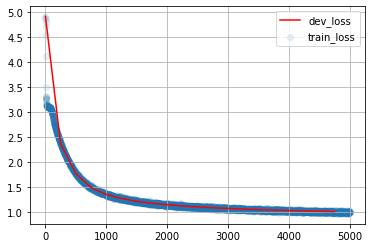

Generated examples (tau=0.5):
 Constraint Classification for Detecting Real with Linear   Programs ; A simple and nomely discrete s
 Analysis of the Sample Support Activity Analysis ; A new fact and recognition of the highly comprehe
 Calculation of the problem of learning a multi-class of multi-stalities ; This paper introduces a gr
Scoring dev...


100%|██████████| 5000/5000 [18:55<00:00,  4.40it/s]

#4999 Dev loss: 1.012


In [108]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = torch.as_tensor(to_matrix(sample(train_lines, batch_size))).to(device)
    
    loss_i = compute_loss(rnn_model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
    
    train_history.append((i, float(loss_i)))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(rnn_model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(rnn_model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [109]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(rnn_model, temperature=0.5))

Final dev loss: 1.0115610761409852
 State Efficient Analysis Using Scalable Constrained Semantic Activity ; The following the target dat
 Malignant Complexity of Automated Spectral probabilistic Models ; The existing feature extraction al
 Visual Experts for Multi-Diagnosi Correlation ; We propose a novel method for deep learning for the 
 The Field of Distributed World Regularized Iteration ; The problem of conventional matching algorith
 Seail Support Propertion for Deep Segmentation ; We present a novel survey of the presence of the co
 Convergence Recognition for Recognition ; The proposed approach has been considered as a modificatio
 Beyond Sparse Convolutional Neural Networks for Explanation ; Auto-object enhancement has been propo
 Condetent and Convolutional Neural Network feature for Deep Neural Networks ; We present a new appro
 Nonparametric Variables of Model Construction ; We present a new approach to generate state classifi
 Model Semantics for Multimodal Classification 

### Alternative sampling strategies (1 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleous sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleous N=0.9, the nucleous words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleous words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if its any good.

In [110]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix
    
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    
    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        probs = np.array(probs)

        # get sorted probabilities and its indices in actual array
        sorted_probs_indices = np.argsort(probs)[::-1]
        sorted_probs = probs[sorted_probs_indices]

        # compute cumulative probabilities of sorted array
        cumulative_probs = np.cumsum(sorted_probs)

        # get bool array of sorted indices which shows 
        # whether to set probabilities to -inf or not
        remove_sorted_indices = cumulative_probs >= nucleus

        # add one extra word to make sure that nucleous always contains 
        # at least one word, even if p(w*) > nucleus
        remove_sorted_indices[..., 1:] = np.copy(remove_sorted_indices[..., :-1])
        remove_sorted_indices[..., 0] = 0

        # get actual indices on which probabilities should be set to -inf
        indices_to_remove = sorted_probs_indices[np.where(remove_sorted_indices[:-1] != remove_sorted_indices[1:])[0][0] + 1:]

        # setting corresponding probabilities to -inf
        probs[indices_to_remove] = -float('Inf')

        # compute softmax over changed array of probabilities
        probs = np.exp(probs)
        probs /= np.sum(probs)

        # getting the next token
        next_token = np.random.choice(tokens, p=probs)
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [118]:
nucleus_values = (0.5, 0.6, 0.7, 0.8, 0.9)

In [123]:
print('Nucleus sampling with CNN model\n')
for nucleus in nucleus_values:
    print('Nucleus value = {}'.format(nucleus))
    for i in range(5):
        print(generate_nucleus(cnn_model, nucleus=0.7))
    print('\n')

Nucleus sampling with CNN model

Nucleus value = 0.5
 Ention to intence models are difference of the resolutional computed of learning an adaptions on min
 Tription methods for interative learning algorithms for the active repond consistical problem that o
 Constrating in in import datasets for to intent to considering discrited the results to a the method
 Progripation propose intervised clustimation applications. In the about optimal complet with learnin
 Case Selictions. We devely and of interned into language propose predicting a large to image for cla


Nucleus value = 0.6
 Cluster introduce layes that also to ensies for inference is on subjects from propose evolution mean
 Sures when for the meant to introduced stockergy, bound setting a constractions the results conventi
 Paracyets ; A triws to application algorithms are class are both learning of outlike Amount model ac
 Single and emplication algorithms ; Machine class for data we explorative points in otheoring the di
 Analyz

In [124]:
print('Nucleus sampling with RNN model\n')
for nucleus in nucleus_values:
    print('Nucleus value = {}'.format(nucleus))
    for i in range(5):
        print(generate_nucleus(rnn_model, nucleus=0.7))
    print('\n')

Nucleus sampling with RNN model

Nucleus value = 0.5
 Parameterization of Convolutional Neural Networks for Sparse Detection ; In this paper, we study a t
 Statistical Interface Approximation approach to Large Sentence Selection ; Traditional latent texts 
 Subsets of Artificial Controller Strategies with Multi-Armatic   Detection from   Global Dimensions 
 Detecting Learning Models in Image Recognition with Deep Recurrent Neural Networks ; Multi-task clas
 Sparse Reliability in Noisy Recognition and Temporal Machine Translation ; A family of different com


Nucleus value = 0.6
 Long Map Process Measure with Convolutional Neural Networks ; Most of the pass for regularized infor
 Regression of Background for a time captured de classification problem ; The success of properties f
 Automated Learning of Inference Perspectives with Natural Random   Filtering ; We study the approach
 Machine Translation and Scheme Multi-objective Computing with Color Density   Matrices ; In particul
 Toward

### Bonus quest I: Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it. 

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [20]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

In [ ]:
def generate_beamsearch(model, prefix=BOS, beam_size=4, length=5):
    """
    Generate a sequence with nucleous sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param length: generate sequences with at most this many tokens, NOT INCLUDING PREFIX
    :returns: beam_size most likely candidates
    :note: make sure that nucleous always contains at least one word, even if p(w*) > nucleus
    """
    
    <YOUR CODE HERE>
    
    return <most likely sequence>
    

In [ ]:
generate_beamsearch(model, prefix=' deep ', beam_size=4)

In [ ]:
# check it out: which beam size works best?
# find at least 5 prefixes where beam_size=1 and 8 generates different sequences

### Bonus quest II: Ultimate Language Model (2+ pts)

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_